### Estimate relative affine biases on the CLASH data using error-in-variables regression

In [1]:
import numpy as np 
import pickle
import matplotlib.pyplot as plt
from os.path import expanduser

from wlenet import config
from wlenet.misc.gpu import avoid_gpu_in_this_process; avoid_gpu_in_this_process()
from wlenet.cluster.cluster_survey import ClusterSurvey
from wlenet.cluster.cluster_dataset_clash import ClusterDatasetClash
from wlenet.misc.sampling import sample_disk_uniform, sample_image
from wlenet.misc.figures import plot_ellipses
from wlenet.misc.regression import linreg_eiv_loglike, fit_gaussian_to_density_2d, transform_gaussian

In [2]:
np.random.seed(1234)
save_biases = True
save_figures = True
save_tables = True
show_debug_figures = False

In [ ]:
with open(expanduser(config['cache_path'] + '/clash_fields_survey.pkl'), 'rb') as f:
    survey = pickle.load(f)

In [4]:
sfe_name = 'r_smoothing_30'
radius = 200
x0, y0 = 250, 250
subsample_ratio = 0.1

In [5]:
g1_rrg_mean_full = np.zeros((0,))
g2_rrg_mean_full = np.zeros((0,))
g1_rrg_var_full = np.zeros((0,))
g2_rrg_var_full = np.zeros((0,))

g1_cnn_mean_full = np.zeros((0,))
g2_cnn_mean_full = np.zeros((0,))
g1_cnn_var_full = np.zeros((0,))
g2_cnn_var_full = np.zeros((0,))

g1_cov_full = np.zeros((0,))
g2_cov_full = np.zeros((0,))

for c in survey.clusters:

    n = int(c.cut['xy'].shape[0] * subsample_ratio)
    x, y = sample_disk_uniform(n, x0, y0, radius)

    g1_rrg_mean = sample_image(c.shear_fields[sfe_name]['cat']['mean'][0,:,:], x, y)
    g2_rrg_mean = sample_image(c.shear_fields[sfe_name]['cat']['mean'][1,:,:], x, y)
    g1_rrg_var  = sample_image(c.shear_fields[sfe_name]['cov'][0,:,:,0,0], x, y)
    g2_rrg_var  = sample_image(c.shear_fields[sfe_name]['cov'][1,:,:,0,0], x, y)
    
    g1_cnn_mean = sample_image(c.shear_fields[sfe_name]['cnn']['mean'][0,:,:], x, y)
    g2_cnn_mean = sample_image(c.shear_fields[sfe_name]['cnn']['mean'][1,:,:], x, y)
    g1_cnn_var  = sample_image(c.shear_fields[sfe_name]['cov'][0,:,:,2,2], x, y)
    g2_cnn_var  = sample_image(c.shear_fields[sfe_name]['cov'][1,:,:,2,2], x, y)
    
    g1_cov = sample_image(c.shear_fields[sfe_name]['cov'][0,:,:,0,2], x, y)
    g2_cov = sample_image(c.shear_fields[sfe_name]['cov'][1,:,:,0,2], x, y)
    
    g1_rrg_mean_full = np.append(g1_rrg_mean_full, g1_rrg_mean)
    g2_rrg_mean_full = np.append(g2_rrg_mean_full, g2_rrg_mean)
    g1_rrg_var_full = np.append(g1_rrg_var_full, g1_rrg_var)
    g2_rrg_var_full = np.append(g2_rrg_var_full, g2_rrg_var)

    g1_cnn_mean_full = np.append(g1_cnn_mean_full, g1_cnn_mean)
    g2_cnn_mean_full = np.append(g2_cnn_mean_full, g2_cnn_mean)
    g1_cnn_var_full = np.append(g1_cnn_var_full, g1_cnn_var)
    g2_cnn_var_full = np.append(g2_cnn_var_full, g2_cnn_var)
    
    g1_cov_full = np.append(g1_cov_full, g1_cov)
    g2_cov_full = np.append(g2_cov_full, g2_cov)
    
    if show_debug_figures:
        
        fig = plt.figure(figsize=(20, 4))
        plt.subplot(1,5,1)
        plt.imshow(c.shear_fields[sfe_name]['cat']['mean'][0,:,:], clim=(-0.25,0.25)); plt.colorbar(); plt.title(c.full_name + ' (RRG)')
        plt.subplot(1,5,2)
        plt.imshow(c.shear_fields[sfe_name]['cat']['mean'][1,:,:], clim=(-0.25,0.25)); plt.colorbar()
        plt.subplot(1,5,3)
        plt.imshow(c.shear_fields[sfe_name]['cov'][0,:,:,0,0]**0.5, clim=(0,0.1)); plt.colorbar()
        plt.subplot(1,5,4)
        plt.imshow(c.shear_fields[sfe_name]['cov'][1,:,:,0,0]**0.5, clim=(0,0.1)); plt.colorbar()
        plt.subplot(1,5,5)
        plt.plot([-0.3, 0.3], [-0.3, 0.3], alpha=0.5)
        plot_ellipses(g1_rrg_mean, g1_cnn_mean, g1_rrg_var, g1_cnn_var, g1_cov, alpha=0.5)
        plt.errorbar(g1_rrg_mean, g1_cnn_mean, xerr=g1_rrg_var**0.5, yerr=g1_cnn_var**0.5, fmt='.', alpha=0.5)
        plt.xlim(-0.3, 0.3)
        plt.ylim(-0.3, 0.3)
        plt.gca().set_aspect('equal', adjustable='box')
        plt.draw()

        fig = plt.figure(figsize=(20, 4))
        plt.subplot(1,5,1)
        plt.imshow(c.shear_fields[sfe_name]['cnn']['mean'][0,:,:], clim=(-0.25,0.25)); plt.colorbar(); plt.title(c.full_name + ' (CNN)')
        plt.subplot(1,5,2)
        plt.imshow(c.shear_fields[sfe_name]['cnn']['mean'][1,:,:], clim=(-0.25,0.25)); plt.colorbar()
        plt.subplot(1,5,3)
        plt.imshow(c.shear_fields[sfe_name]['cov'][0,:,:,2,2]**0.5, clim=(0,0.1)); plt.colorbar()
        plt.subplot(1,5,4)
        plt.imshow(c.shear_fields[sfe_name]['cov'][1,:,:,2,2]**0.5, clim=(0,0.1)); plt.colorbar()
        plt.subplot(1,5,5)
        plt.plot([-0.3, 0.3], [-0.3, 0.3], alpha=0.5)
        plot_ellipses(g2_rrg_mean, g2_cnn_mean, g2_rrg_var, g2_cnn_var, g1_cov, alpha=0.5)
        plt.errorbar(g2_rrg_mean, g2_cnn_mean, xerr=g2_rrg_var**0.5, yerr=g2_cnn_var**0.5, fmt='.', alpha=0.5)
        plt.xlim(-0.3, 0.3)
        plt.ylim(-0.3, 0.3)
        plt.gca().set_aspect('equal', adjustable='box')
        plt.draw()

In [6]:
nni1 = ~np.isnan(g1_rrg_mean_full) * ~np.isnan(g1_cnn_mean_full)
nni2 = ~np.isnan(g2_rrg_mean_full) * ~np.isnan(g2_cnn_mean_full)

thetas = np.linspace(np.pi/4-0.025, np.pi/4+0.075, 50)
b_perps = np.linspace(-0.01, 0.01, 50)

loglike1 = linreg_eiv_loglike(g1_rrg_mean_full[nni1], g1_cnn_mean_full[nni1], 
                              g1_rrg_var_full[nni1], g1_cnn_var_full[nni1], g1_cov_full[nni1], thetas, b_perps)

loglike2 = linreg_eiv_loglike(g2_rrg_mean_full[nni2], g2_cnn_mean_full[nni2], 
                              g2_rrg_var_full[nni2], g2_cnn_var_full[nni2], g2_cov_full[nni2], thetas, b_perps)

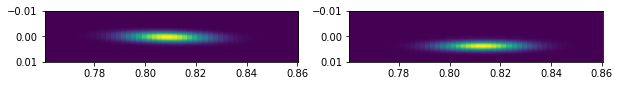

In [7]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(np.exp(loglike1-np.max(loglike1)), extent=[thetas[0], thetas[-1], b_perps[-1], b_perps[0]])
plt.subplot(1,2,2)
plt.imshow(np.exp(loglike2-np.max(loglike2)), extent=[thetas[0], thetas[-1], b_perps[-1], b_perps[0]])

In [8]:
mu1, cov1 = fit_gaussian_to_density_2d(np.exp(loglike1-np.max(loglike1)), thetas, b_perps)
mu2, cov2 = fit_gaussian_to_density_2d(np.exp(loglike2-np.max(loglike2)), thetas, b_perps)

In [9]:
import sympy as sp
sp.init_printing()

theta = sp.Symbol('theta', real=True)   
b_perp = sp.Symbol('b_perp', real=True)

m = sp.tan(theta)
b = b_perp / sp.cos(theta)

x = sp.Matrix([[theta], [b_perp]])
y = sp.Matrix([[m], [b]])

In [10]:
mu1_, cov1_ = transform_gaussian(mu1, cov1, x, y)
mu2_, cov2_ = transform_gaussian(mu2, cov2, x, y)
m1, b1, sigma_m1, sigma_b1 = mu1_[0], mu1_[1], cov1_[0,0]**0.5, cov1_[1,1]**0.5
m2, b2, sigma_m2, sigma_b2 = mu2_[0], mu2_[1], cov2_[0,0]**0.5, cov2_[1,1]**0.5
print(m1, '±', sigma_m1, ',', m2, '±', sigma_m2)
print(b1, '±', sigma_b1, ',', b2, '±', sigma_b2)

1.04750116214420 ± 0.0235599280080565 , 1.05667807630219 ± 0.0244928148218595
0.000300148958203482 ± 0.00187014911584326 , 0.00534074617422720 ± 0.00186057908823812


In [11]:
calib = np.array([b1, m1-1, b2, m2-1]).astype('float64')
if save_biases:
    np.save(expanduser(config['estimation_path'] + '/clash_biases.npy'), calib)

In [12]:
from astropy.table import Table
from astropy.io import ascii

c1 = ['%0.4f±%0.4f' % (calib[0], sigma_b1)]
m1 = ['%0.3f±%0.3f' % (calib[1], sigma_m1)]
c2 = ['%0.4f±%0.4f' % (calib[2], sigma_b2)]
m2 = ['%0.3f±%0.3f' % (calib[3], sigma_m2)]

estimators = ['CNN']
names = [' ', '$c_1$', '$m_1$', '$c_2$', '$m_2$']
rows = [estimators, c1, m1, c2, m2]
tbl_rel_calib = Table(rows, names=names)
tbl_rel_calib

,$c_1$,$m_1$,$c_2$,$m_2$
str3,str13,str11,str13,str11
CNN,0.0003±0.0019,0.048±0.024,0.0053±0.0019,0.057±0.024


In [13]:
if save_tables:
    tbl_path = expanduser(config['figure_path'] + '/estimation/clash_biases.tex')
    tbl_rel_calib.write(tbl_path, format='ascii.latex', latexdict=ascii.latex.latexdicts['AA'], col_align='lcccccr',
                           caption="Affine bias model parameters correcting CNN estimates s.t. they are unbiased relative to RRG estimates on the full CLASH dataset")

In [14]:
nni = ~np.isnan(g1_rrg_mean_full) * ~np.isnan(g2_rrg_mean_full)

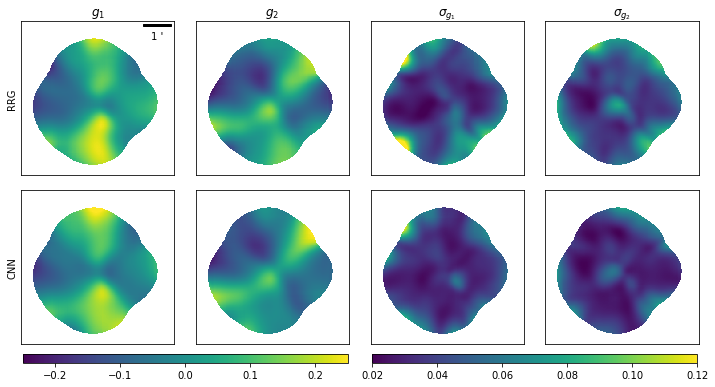

In [15]:
from matplotlib_scalebar.scalebar import ScaleBar
from matplotlib_scalebar.dimension import _Dimension

clash = ClusterDatasetClash()
c = survey.clusters[clash.cluster_names_dict['macs1720']]
mini_pixel_scale_arcmin = clash.get_pixel_scale() * survey.cluster_template.mini_scale_factor**-1 * 60**-1
scalebar = ScaleBar(dx=mini_pixel_scale_arcmin, dimension=_Dimension('m', latexrepr="'"))


fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(10, 5))
plt.subplot(2,4,1)
im_g = plt.imshow(c.shear_fields[sfe_name]['cat']['mean'][0,:,:], clim=(-0.25,0.25))
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
plt.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)  
plt.ylabel('RRG')
plt.title('$g_1$')
plt.gca().add_artist(scalebar)

plt.subplot(2,4,2)
plt.imshow(c.shear_fields[sfe_name]['cat']['mean'][1,:,:], clim=(-0.25,0.25))
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
plt.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
plt.title('$g_2$')

plt.subplot(2,4,3)
im_s = plt.imshow(c.shear_fields[sfe_name]['cov'][0,:,:,0,0]**0.5, clim=(0.02,0.12))
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
plt.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
plt.title('$\sigma_{g_1}$')

plt.subplot(2,4,4)
plt.imshow(c.shear_fields[sfe_name]['cov'][1,:,:,0,0]**0.5, clim=(0.02,0.12))
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
plt.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)    
plt.title('$\sigma_{g_2}$')

plt.subplot(2,4,5)
plt.imshow(c.shear_fields[sfe_name]['cnn']['mean'][0,:,:], clim=(-0.25,0.25))
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
plt.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)  
plt.ylabel('CNN')
plt.subplot(2,4,6)
plt.imshow(c.shear_fields[sfe_name]['cnn']['mean'][1,:,:], clim=(-0.25,0.25))
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
plt.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)  
plt.subplot(2,4,7)
plt.imshow(c.shear_fields[sfe_name]['cov'][0,:,:,2,2]**0.5, clim=(0.02,0.12))
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
plt.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)  
plt.subplot(2,4,8)
plt.imshow(c.shear_fields[sfe_name]['cov'][1,:,:,2,2]**0.5, clim=(0.02,0.12))
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
plt.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
plt.tight_layout()

plt.colorbar(im_g, ax=ax, orientation='horizontal', aspect=35, anchor=(-0.265, -1.62), shrink=0.582)
plt.colorbar(im_s, ax=ax, orientation='horizontal', aspect=35, anchor=(+1.234, -6.8825), shrink=0.582)

if save_figures:
    fig_path = expanduser(config['figure_path'] + '/estimation/clash_smooth_fields.pdf')
    plt.savefig(fig_path, bbox_inches="tight")

In [16]:
from wlenet.models.calibrate import step_bias_correct
g_corr = step_bias_correct(np.column_stack((g1_cnn_mean_full[nni], g2_cnn_mean_full[nni])), calib)

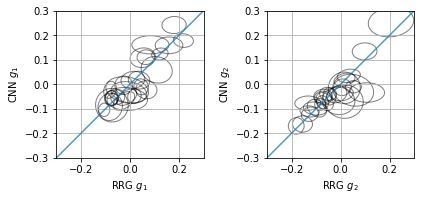

In [17]:
n = int(c.cut['xy'].shape[0] * subsample_ratio)
x, y = sample_disk_uniform(n, x0, y0, radius)
c = survey.clusters[clash.cluster_names_dict['macs1720']]

g1_rrg_mean = sample_image(c.shear_fields[sfe_name]['cat']['mean'][0,:,:], x, y)
g2_rrg_mean = sample_image(c.shear_fields[sfe_name]['cat']['mean'][1,:,:], x, y)

g1_rrg_var  = sample_image(c.shear_fields[sfe_name]['cov'][0,:,:,0,0], x, y)
g2_rrg_var  = sample_image(c.shear_fields[sfe_name]['cov'][1,:,:,0,0], x, y)

g1_cnn_mean = sample_image(c.shear_fields[sfe_name]['cnn']['mean'][0,:,:], x, y)
g2_cnn_mean = sample_image(c.shear_fields[sfe_name]['cnn']['mean'][1,:,:], x, y)

g1_cnn_var  = sample_image(c.shear_fields[sfe_name]['cov'][0,:,:,2,2], x, y)
g2_cnn_var  = sample_image(c.shear_fields[sfe_name]['cov'][1,:,:,2,2], x, y)

g1_cov = sample_image(c.shear_fields[sfe_name]['cov'][0,:,:,0,2], x, y)
g2_cov = sample_image(c.shear_fields[sfe_name]['cov'][1,:,:,0,2], x, y)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(6.0, 3.2))

plt.subplot(1,2,1)
plt.plot([-0.3, 0.3], [-0.3, 0.3], alpha=0.75)
plot_ellipses(g1_rrg_mean, g1_cnn_mean, g1_rrg_var, g1_cnn_var, g1_cov, alpha=0.5)
plt.xlim(-0.3, 0.3)
plt.ylim(-0.3, 0.3)
plt.ylabel('CNN $g_1$')
plt.xlabel('RRG $g_1$')
plt.gca().set_aspect('equal', adjustable='box')
plt.grid('on')


plt.subplot(1,2,2)
plt.plot([-0.3, 0.3], [-0.3, 0.3], alpha=0.75)
plot_ellipses(g2_rrg_mean, g2_cnn_mean, g2_rrg_var, g2_cnn_var, g2_cov, alpha=0.5)
plt.xlim(-0.3, 0.3)
plt.ylim(-0.3, 0.3)
plt.ylabel('CNN $g_2$')
plt.xlabel('RRG $g_2$')
plt.gca().set_aspect('equal', adjustable='box')
plt.grid('on')
plt.tight_layout()

if save_figures:
    fig_path = expanduser(config['figure_path'] + '/estimation/clash_biases_specific.pdf')
    plt.savefig(fig_path, bbox_inches="tight")

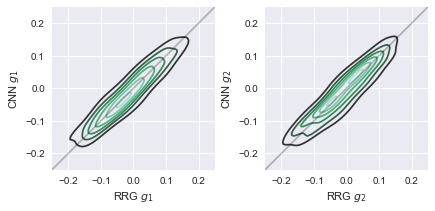

In [18]:
import seaborn as sns

nni1 = ~np.isnan(g1_rrg_mean_full) * ~np.isnan(g1_cnn_mean_full)
nni2 = ~np.isnan(g2_rrg_mean_full) * ~np.isnan(g2_cnn_mean_full)

plt.figure(figsize=(7,3))

plt.subplot(1,2,1)
sns.kdeplot(g1_rrg_mean_full[nni], g_corr[:,0], n_levels=7)
plt.plot([-0.3, 0.3], [-0.3, 0.3], alpha=0.25, color='k')   
plt.xlim(-0.25, 0.25)
plt.ylim(-0.25, 0.25)
plt.xlabel('RRG $g_1$')
plt.ylabel('CNN $g_1$')
plt.gca().set_aspect('equal', adjustable='box')
plt.draw()

plt.subplot(1,2,2)
sns.kdeplot(g2_rrg_mean_full[nni], g_corr[:,1], n_levels=7)
plt.plot([-0.3, 0.3], [-0.3, 0.3], alpha=0.25, color='k')   
plt.xlim(-0.25, 0.25)
plt.ylim(-0.25, 0.25)
plt.xlabel('RRG $g_2$')
plt.ylabel('CNN $g_2$')
plt.gca().set_aspect('equal', adjustable='box')
plt.draw()

if save_figures:
    fig_path = expanduser(config['figure_path'] + '/estimation/clash_biases.pdf')
    plt.savefig(fig_path, bbox_inches="tight")